In [1]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
import chainer.serializers as serializers
from chainer import cuda
import cupy
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from data_utils import *
import models, nn, graph_ops

In [2]:
'''
Set array backend, seed
'''
def seed_rng(s):
    xp.random.seed(s)
    np.random.seed(s)
rng_seed = 98765
use_gpu = True
xp = cupy if use_gpu >= 0 else np
print('rng_seed = {}, xp: {}'.format(rng_seed, xp))

rng_seed = 98765, xp: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>


In [3]:
'''
Dataset parameters
'''
num_particles = 16 # defaults 16**3
#zX, zY = 0.4, 0.0
zX, zY = 6.0, 4.0
X,Y = load_data(zX, zY, num_particles)
X, Y = normalize(X), normalize(Y)
print('X.shape: {}, redshifts z{}'.format(X.shape, (zX, zY)))

X.shape: (1000, 4096, 6), redshifts z(6.0, 4.0)


In [ ]:
'''
Utils
'''
class ModelTrainer():# should really look into chainer's trainer class
    def __init__(self, model, opt, n_iters=1000):
        self.model = model
        self.opt = opt
        self.n_iters = 1000
        self.loss_history = xp.zeros((n_iters))
        self.rng_seed = 98765
    
    def seed_rng(self):
        xp.random.seed(self.rng_seed)
        np.random.seed(self.rng_seed)
    
    def extract_data(self, data):
        X, Y = data
        return xp.copy(X), xp.copy(Y)
    
    def train(self, data, mb_size):
        X, Y = data
    
    def validation(self, data, mb_size):
        X, Y = data
        M, N, D = X.shape
        assert M % mb_size == 0
        with chainer.using_config('train', False):
            for batch in range(M // mb_size):
                
    
    def __call__(self, data, validation=False, mb_size=8):
        X, Y = self.extract_data(data)
        x_in = x_hat = x_true = None
        self.seed_rng()
        _x_in, _x_true = gpunext_minibatch([X, Y], mb_size)
        with chainer.using_config('train', not validation):
            for cur_iter in range(self.n_iters)
            
            
            
            
        
        
        
        
        
    

In [ ]:
for nparticles in num_particles:
    for zX, lst_zY in rs_tups.items():
        X = normalize(load_datum(zX, nparticles), cupy_out=True)
        for zY in lst_zY:
            redshift_tuple = (zX, zY)
            Y = normalize(load_datum(zY, nparticles), cupy_out=True)
            # model/opt
            for use_graph in graph_use:
                mtype = 'kgraph_' if use_graph else 'set_'
                print('n_P: {}, zX, zY: {} {}, model: {}'.format(nparticles, zX, zY, mtype))
                seed_rng(rng_seed)
                #model = models.ScaleVelocity(scalar=True)
                if not use_graph:
                    channels = [6, 32, 128, 256, 128, 32, 256, 16, 3]
                    model = models.nBodyModel(channels)
                    n_iters = 2000
                else:
                    channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3]
                    model = models.nBodyModel(channels, use_graph=use_graph)
                    n_iters = 3000
                model.to_gpu()
                seed_rng(rng_seed)
                optimizer = optimizers.Adam(alpha=0.01)
                optimizer.setup(model)
                # train loop
                loss_history = xp.zeros((n_iters), dtype=xp.float32)
                seed_rng(rng_seed)
                for cur_iter in range(n_iters):
                    model.zerograds()
                    _x_in, _x_true = gpunext_minibatch([xp.copy(X), Y], mb_size)
                    x_in, x_true = to_var_xp([_x_in, _x_true])
                    graphNN = None
                    if use_graph:
                        graphNN = graph_ops.GraphNN(cuda.to_cpu(_x_in), 'knn', 14)
                    x_hat = model(x_in, graphNN=graphNN)
                    loss = nn.get_MSE(x_hat, x_true, boundary=bound)
                    loss.backward()
                    optimizer.update()
                    loss_history[cur_iter] = loss.data
                    """
                    if (cur_iter+1) % 10 == 0:
                        y = loss_history[:cur_iter+1]
                        plt.close('all')
                        title = 'n_P {} RS {}, Iteration: {}, loss: {:.4}'.format(nparticles, redshift_tuple, cur_iter+1, y[-1])
                        fig = plot_training_curve(y, cur_iter, yclip=0.01, title=title)
                        display.display(plt.gcf())
                        display.clear_output(wait=True)
                        time.sleep(0.0001)
                    """
                save_name = mtype + '{}_{}_{}'.format(nparticles, zX, zY)
                model_save_path = model_save_dir + save_name
                data_save_path = data_save_dir + save_name + '_'
                xp.save(model_save_path + '_LossHistory', loss_history)
                save_model((model, optimizer), model_save_path)
                xp.save(data_save_path + 'input', x_in.data)
                xp.save(data_save_path + 'hat', x_hat.data)
                xp.save(data_save_path + 'truth', x_true.data)
                loss_history = None; del loss_history;
                model = optimizer = None; del model; del optimizer;

In [ ]:
'''
Models
'''
# Model invariant settings
LR = 0.01
BOUND = 0.095

# GRAPH MODEL
graph_channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
graph_model = models.nBodyModel(graph_channels, use_graph=True)
graph_model.to_gpu()
graph_opt = optimizers.Adam(alpha=LR)

# SET MODEL
set_channels = [6, 32, 128, 256, 128, 32, 256, 16, 3]
set_model = models.nBodyModel(set_channels, use_graph=False)
set_model.to_gpu()
set_opt = optimizers.Adam(alpha=LR)

# VEL MODEL
vel_model = models.ScaleVelocity(scalar=True)
vel_model.to_gpu()
vel_opt = optimizers.Adam(alpha=LR)

In [4]:
'''
Model, optimizer, and training setup
'''
# Model setup
graph_channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
set_channels = [6, 32, 128, 256, 128, 32, 256, 16, 3]

use_graph = False
nn_search_type = ('knn', 14)
channels = graph_channels if use_graph else set_channels
seed_rng(rng_seed)
#model = models.nBodyModel(channels, use_graph=use_graph)
model = models.ScaleVelocity(scalar=True)
if use_gpu: model.to_gpu() # can specify gpu device with device=*

# Optimizer setup
lr = 0.01
optimizer = optimizers.Adam(alpha=lr)
optimizer.setup(model)

# Training setup
model_dir = './Models/'
interm_model_dir = model_dir + 'interm/'
if not os.path.exists(interm_model_dir): os.makedirs(interm_model_dir)
bound = 0.095
batch_size = 8
n_iters = 1000
loss_history = np.zeros((n_iters), dtype=np.float32)
'''
naming postfix convention:
|dataset|batch_size|iterations|learning_rate|
eg: 16_64_1000_001
'''
#model_name = 'graphmodel_4.0-0.2_16_8_2000_01_'
model_name = 'testing_'
#model_name = 'velmodel_4.0-0.2_16_8_2000_01_'

seed_rng(rng_seed)
x_in, x_true = next_minibatch([X,Y], batch_size)

print('Session info: \nrng_seed: {}, ndarray_backend: {}'.format(rng_seed, xp))
print('redshifts: {}, num_particles: {}**3, data.shape: {}'.format((zX,zY), num_particles, X.shape))
print('n_iters: {}, batch_size: {}, lr: {}'.format(n_iters, batch_size, lr))
print('graph_model: {}, channels: {}'.format(use_graph, channels))

Session info: 
rng_seed: 98765, ndarray_backend: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
redshifts: (6.0, 4.0), num_particles: 16**3, data.shape: (1000, 4096, 6)
n_iters: 1000, batch_size: 8, lr: 0.01
graph_model: False, channels: [6, 32, 128, 256, 128, 32, 256, 16, 3]


In [9]:
for nparticles in num_particles:
    for zX, lst_zY in rs_tups.items():
        X = normalize(load_datum(zX, nparticles), cupy_out=True)
        for zY in lst_zY:
            redshift_tuple = (zX, zY)
            Y = normalize(load_datum(zY, nparticles), cupy_out=True)
            # model/opt
            for use_graph in graph_use:
                mtype = 'kgraph_' if use_graph else 'set_'
                print('n_P: {}, zX, zY: {} {}, model: {}'.format(nparticles, zX, zY, mtype))
                seed_rng(rng_seed)
                #model = models.ScaleVelocity(scalar=True)
                if not use_graph:
                    channels = [6, 32, 128, 256, 128, 32, 256, 16, 3]
                    model = models.nBodyModel(channels)
                    n_iters = 2000
                else:
                    channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3]
                    model = models.nBodyModel(channels, use_graph=use_graph)
                    n_iters = 3000
                model.to_gpu()
                seed_rng(rng_seed)
                optimizer = optimizers.Adam(alpha=0.01)
                optimizer.setup(model)
                # train loop
                loss_history = xp.zeros((n_iters), dtype=xp.float32)
                seed_rng(rng_seed)
                for cur_iter in range(n_iters):
                    model.zerograds()
                    _x_in, _x_true = gpunext_minibatch([xp.copy(X), Y], mb_size)
                    x_in, x_true = to_var_xp([_x_in, _x_true])
                    graphNN = None
                    if use_graph:
                        graphNN = graph_ops.GraphNN(cuda.to_cpu(_x_in), 'knn', 14)
                    x_hat = model(x_in, graphNN=graphNN)
                    loss = nn.get_MSE(x_hat, x_true, boundary=bound)
                    loss.backward()
                    optimizer.update()
                    loss_history[cur_iter] = loss.data
                    """
                    if (cur_iter+1) % 10 == 0:
                        y = loss_history[:cur_iter+1]
                        plt.close('all')
                        title = 'n_P {} RS {}, Iteration: {}, loss: {:.4}'.format(nparticles, redshift_tuple, cur_iter+1, y[-1])
                        fig = plot_training_curve(y, cur_iter, yclip=0.01, title=title)
                        display.display(plt.gcf())
                        display.clear_output(wait=True)
                        time.sleep(0.0001)
                    """
                save_name = mtype + '{}_{}_{}'.format(nparticles, zX, zY)
                model_save_path = model_save_dir + save_name
                data_save_path = data_save_dir + save_name + '_'
                xp.save(model_save_path + '_LossHistory', loss_history)
                save_model((model, optimizer), model_save_path)
                xp.save(data_save_path + 'input', x_in.data)
                xp.save(data_save_path + 'hat', x_hat.data)
                xp.save(data_save_path + 'truth', x_true.data)
                loss_history = None; del loss_history;
                model = optimizer = None; del model; del optimizer;

tups: [(6.0, 4.0), (6.0, 2.0), (6.0, 1.5), (6.0, 1.2), (6.0, 1.0), (6.0, 0.8), (6.0, 0.6), (6.0, 0.4), (6.0, 0.2), (6.0, 0.0), (4.0, 2.0), (4.0, 1.5), (4.0, 1.2), (4.0, 1.0), (4.0, 0.8), (4.0, 0.6), (4.0, 0.4), (4.0, 0.2), (4.0, 0.0), (2.0, 1.5), (2.0, 1.2), (2.0, 1.0), (2.0, 0.8), (2.0, 0.6), (2.0, 0.4), (2.0, 0.2), (2.0, 0.0), (1.5, 1.2), (1.5, 1.0), (1.5, 0.8), (1.5, 0.6), (1.5, 0.4), (1.5, 0.2), (1.5, 0.0), (1.2, 1.0), (1.2, 0.8), (1.2, 0.6), (1.2, 0.4), (1.2, 0.2), (1.2, 0.0), (1.0, 0.8), (1.0, 0.6), (1.0, 0.4), (1.0, 0.2), (1.0, 0.0), (0.8, 0.6), (0.8, 0.4), (0.8, 0.2), (0.8, 0.0), (0.6, 0.4), (0.6, 0.2), (0.6, 0.0), (0.4, 0.2), (0.4, 0.0), (0.2, 0.0)]
X.shape: (1000, 4096, 6), redshifts z(6.0, 4.0)
iter: 0


AssertionError: 

In [13]:
model.theta.W

variable W([[[ nan]]])

In [5]:
'''
Train loop
'''
for cur_iter in range(1, n_iters + 1):
    model.zerograds()
    idx_iter = cur_iter-1
    save_cond = (cur_iter % 10 == 0)
    # create mini-batches for training
    _x_in, _x_true = next_minibatch([X,Y], batch_size)
    x_in, x_true   = to_variable([_x_in, _x_true])
    
    # get prediction and loss
    graphNN = graph_ops.GraphNN(_x_in, *nn_search_type) if use_graph else None
    x_hat = model(x_in, graphNN=graphNN, add=True) # prediction
    loss = nn.get_MSE(x_hat, x_true, boundary=bound) # bound = 0.095
    
    # backprop and update
    loss.backward()
    optimizer.update()
    print('model.theta.W: {}'.format(cuda.to_cpu(model.theta.W.data)))
    loss_history[idx_iter] = cuda.to_cpu(loss.data)
    """
    if save_cond:
        np.save(model_dir + 'loss_history', loss_history)
        y = loss_history[:cur_iter]
        plt.close('all')
        fig = plot_training_curve(y, cur_iter, yclip=0.0)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        if cur_iter % 50 == 0: save_model((model, optimizer), interm_model_dir + model_name + str(cur_iter))
#save_model((model, optimizer), model_dir + model_name)"""

model.theta.W: [[[ 0.99000001]]]
model.theta.W: [[[ 0.98001444]]]
model.theta.W: [[[ 0.97004968]]]
model.theta.W: [[[ 0.96007454]]]
model.theta.W: [[[ 0.95003521]]]
model.theta.W: [[[ 0.94006431]]]
model.theta.W: [[[ 0.93021882]]]
model.theta.W: [[[ 0.92039669]]]
model.theta.W: [[[ 0.91065866]]]
model.theta.W: [[[ 0.90105665]]]
model.theta.W: [[[ 0.89141309]]]
model.theta.W: [[[ 0.88176847]]]
model.theta.W: [[[ 0.8721503]]]
model.theta.W: [[[ 0.86258537]]]
model.theta.W: [[[ 0.85295194]]]
model.theta.W: [[[ 0.84335023]]]
model.theta.W: [[[ 0.83377898]]]
model.theta.W: [[[ 0.82423866]]]
model.theta.W: [[[ 0.8147043]]]
model.theta.W: [[[ 0.80514014]]]
model.theta.W: [[[ 0.79566902]]]
model.theta.W: [[[ 0.78621465]]]
model.theta.W: [[[ 0.7767849]]]
model.theta.W: [[[ 0.76737952]]]
model.theta.W: [[[ 0.75802231]]]
model.theta.W: [[[ 0.74868077]]]
model.theta.W: [[[ 0.73936576]]]
model.theta.W: [[[ 0.73011148]]]
model.theta.W: [[[ 0.72097844]]]
model.theta.W: [[[ 0.71188295]]]
model.theta.W

model.theta.W: [[[ 0.00548003]]]
model.theta.W: [[[ 0.00541938]]]
model.theta.W: [[[ 0.00536111]]]
model.theta.W: [[[ 0.00530565]]]
model.theta.W: [[[ 0.00525257]]]
model.theta.W: [[[ 0.00520168]]]
model.theta.W: [[[ 0.00515271]]]
model.theta.W: [[[ 0.00510613]]]
model.theta.W: [[[ 0.00506162]]]
model.theta.W: [[[ 0.00501918]]]
model.theta.W: [[[ 0.0049789]]]
model.theta.W: [[[ 0.00494048]]]
model.theta.W: [[[ 0.00490386]]]
model.theta.W: [[[ 0.00486883]]]
model.theta.W: [[[ 0.00483558]]]
model.theta.W: [[[ 0.00480407]]]
model.theta.W: [[[ 0.0047741]]]
model.theta.W: [[[ 0.00474552]]]
model.theta.W: [[[ 0.00471839]]]
model.theta.W: [[[ 0.00469246]]]
model.theta.W: [[[ 0.00466766]]]
model.theta.W: [[[ 0.00464403]]]
model.theta.W: [[[ 0.00462145]]]
model.theta.W: [[[ 0.00460006]]]
model.theta.W: [[[ 0.00457973]]]
model.theta.W: [[[ 0.00456035]]]
model.theta.W: [[[ 0.00454186]]]
model.theta.W: [[[ 0.00452427]]]
model.theta.W: [[[ 0.00450762]]]
model.theta.W: [[[ 0.00449187]]]
model.theta.

model.theta.W: [[[ 0.00422969]]]
model.theta.W: [[[ 0.00422972]]]
model.theta.W: [[[ 0.00422972]]]
model.theta.W: [[[ 0.00422971]]]
model.theta.W: [[[ 0.00422973]]]
model.theta.W: [[[ 0.00422975]]]
model.theta.W: [[[ 0.00422977]]]
model.theta.W: [[[ 0.00422978]]]
model.theta.W: [[[ 0.00422979]]]
model.theta.W: [[[ 0.0042298]]]
model.theta.W: [[[ 0.00422979]]]
model.theta.W: [[[ 0.0042298]]]
model.theta.W: [[[ 0.00422982]]]
model.theta.W: [[[ 0.00422984]]]
model.theta.W: [[[ 0.00422987]]]
model.theta.W: [[[ 0.00422991]]]
model.theta.W: [[[ 0.00422994]]]
model.theta.W: [[[ 0.00422999]]]
model.theta.W: [[[ 0.00423001]]]
model.theta.W: [[[ 0.00423002]]]
model.theta.W: [[[ 0.00423004]]]
model.theta.W: [[[ 0.00423004]]]
model.theta.W: [[[ 0.00423006]]]
model.theta.W: [[[ 0.00423006]]]
model.theta.W: [[[ 0.00423008]]]
model.theta.W: [[[ 0.0042301]]]
model.theta.W: [[[ 0.00423018]]]
model.theta.W: [[[ 0.00423021]]]
model.theta.W: [[[ 0.00423027]]]
model.theta.W: [[[ 0.0042303]]]
model.theta.W:

model.theta.W: [[[ 0.00423056]]]
model.theta.W: [[[ 0.00423048]]]
model.theta.W: [[[ 0.00423042]]]
model.theta.W: [[[ 0.00423037]]]
model.theta.W: [[[ 0.00423035]]]
model.theta.W: [[[ 0.00423032]]]
model.theta.W: [[[ 0.00423029]]]
model.theta.W: [[[ 0.00423026]]]
model.theta.W: [[[ 0.00423026]]]
model.theta.W: [[[ 0.00423024]]]
model.theta.W: [[[ 0.00423022]]]
model.theta.W: [[[ 0.00423024]]]
model.theta.W: [[[ 0.00423021]]]
model.theta.W: [[[ 0.00423016]]]
model.theta.W: [[[ 0.00423023]]]
model.theta.W: [[[ 0.00423033]]]
model.theta.W: [[[ 0.00423042]]]
model.theta.W: [[[ 0.0042305]]]
model.theta.W: [[[ 0.00423056]]]
model.theta.W: [[[ 0.00423058]]]
model.theta.W: [[[ 0.00423062]]]
model.theta.W: [[[ 0.00423063]]]
model.theta.W: [[[ 0.00423059]]]
model.theta.W: [[[ 0.00423054]]]
model.theta.W: [[[ 0.00423048]]]
model.theta.W: [[[ 0.00423042]]]
model.theta.W: [[[ 0.00423041]]]
model.theta.W: [[[ 0.0042304]]]
model.theta.W: [[[ 0.00423039]]]
model.theta.W: [[[ 0.00423036]]]
model.theta.

KeyboardInterrupt: 

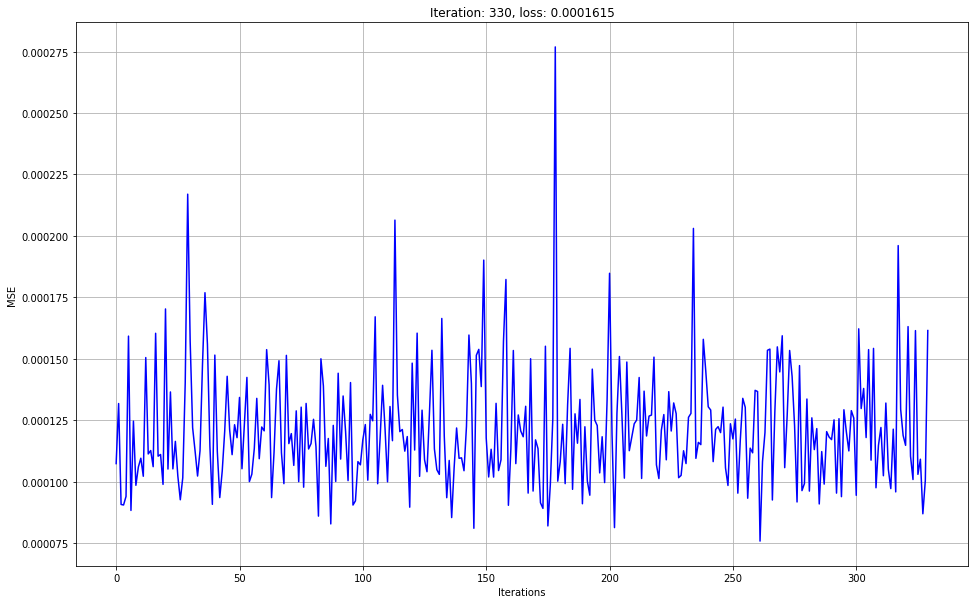

In [9]:
'''
Train loop
'''
theta = 0.01197983
def bounded_mse_function(xhat, xtrue, bound=0.095):
    bidx = np.all(np.logical_and(bound<xtrue, xtrue<1-bound),axis=-1)
    return np.mean(np.sum(np.square(xhat[bidx] - xtrue[bidx]),axis=-1))

LH = np.zeros((n_iters,))
for cur_iter in range(1, n_iters + 1):
    #model.zerograds()
    idx_iter = cur_iter-1
    save_cond = (cur_iter % 10 == 0)
    # create mini-batches for training
    xin, xtrue = next_minibatch([np.copy(X),np.copy(Y)], batch_size)
    x_hat = theta * xin[...,3:] + xin[...,:3]
    loss = bounded_mse_function(x_hat, xtrue[...,:3])

    LH[idx_iter] = loss
    if save_cond:
        #np.save(model_dir + 'loss_history', loss_history)
        y = LH[:cur_iter]
        plt.close('all')
        fig = plot_training_curve(y, cur_iter, yclip=0.0)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        #if cur_iter % 50 == 0: save_model((model, optimizer), interm_model_dir + model_name + str(cur_iter))
#save_model((model, optimizer), model_dir + model_name)

In [6]:
#VECTOR THETA: variable W([[[ 0.01199752,  0.01197837,  0.01196339]]])
#SCALAR THETA: variable W([[[ 0.01197983]]])
model.theta.W

variable W([[[ 0.01197983]]])

In [6]:
'''
save train data
'''
xt = cuda.to_cpu(x_true.data)
xh = cuda.to_cpu(x_hat.data)
save_name = model_dir + model_name + 'train_'
save_data_batches((_x_in, xt, xh), save_name)
print('savename: {}'.format(model_name))

data saved
savename: graphmodel_1.2-0.0_16_8_2000_01_


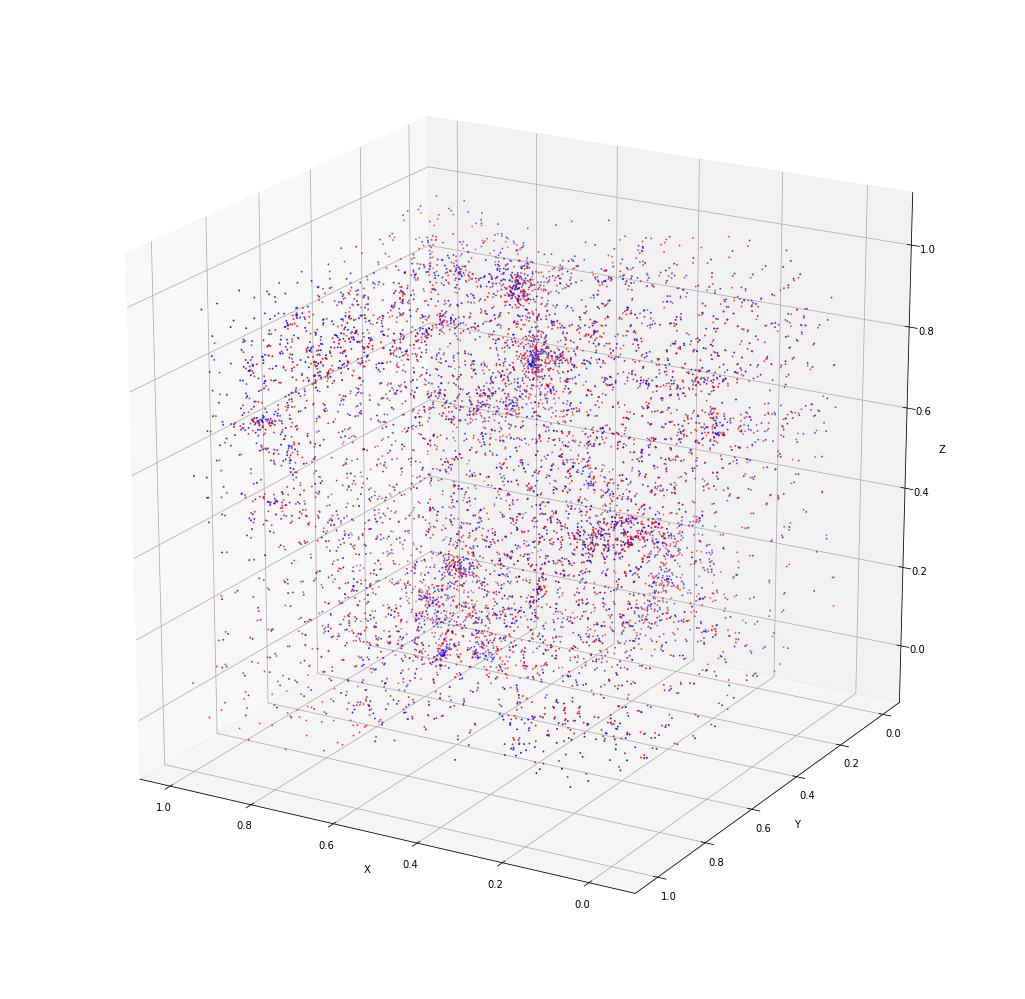

In [12]:
'''
plot point cloud
'''
j = 2
fsize = (18,18)
particle_size = .9
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image

In [7]:
'''
Save current
'''
#model_name = 'graphmodel_1.2-0.0_16_8_2000_01_'
print('save {} loss history'.format(model_name))
np.save(model_dir + 'loss_history_' + model_name, loss_history)

save graphmodel_1.2-0.0_16_8_2000_01_ loss history


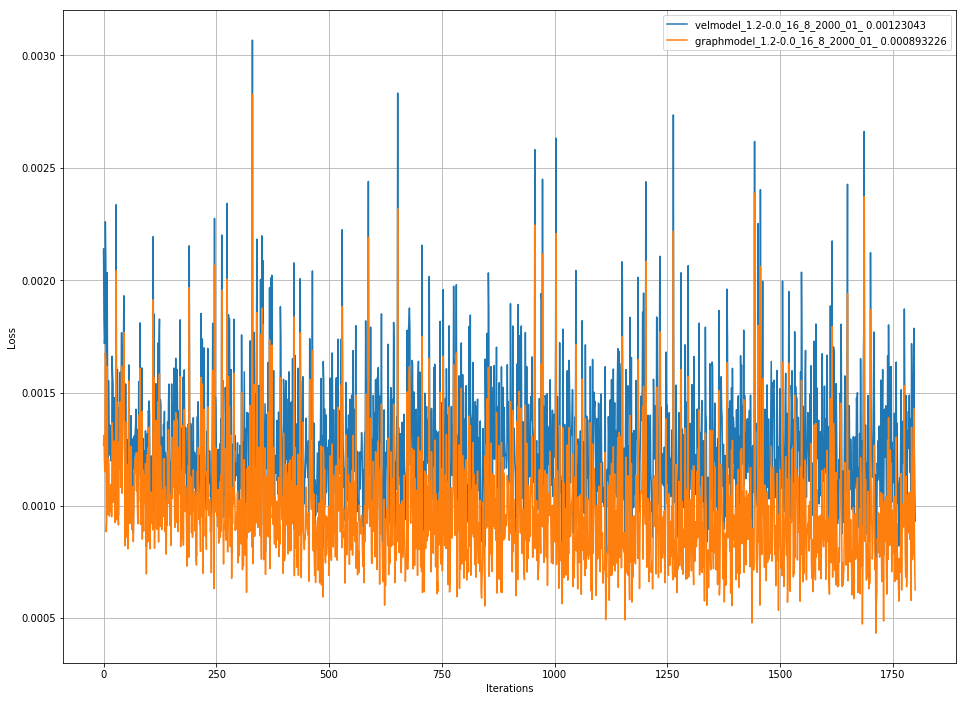

In [9]:
'''
Compare loss curves
'''
"""
loss_labels = ['setmodel_16_8_1000_01_',
               #'graphmodel_14_16_8_1000_01_',
               'velmodel_16_8_1000_01_',
               #'graphmodel_14_16_8_2000_01_',
               #'graphmodel2_14_16_8_2000_01_',
               #'graphmodel2_14_16_8_1000_01_',
               'testing_',
              ]
loss_labels = [#'setmodel_1.2-0.0_16_8_1000_01_',
               #'velmodel_1.2-0.0_16_8_1000_01_',
               'velmodel_1.2-0.0_16_8_2000_01_',
               'graphmodel_1.2-0.0_16_8_2000_01_',
              ]
loss_labels32 = ['setmodel_32_8_1000_01_',    
                ]

loss_files = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels]
loss_curves = {label:loss for label,loss in zip(loss_labels, loss_files)}
iterations = np.arange(loss_files[0].shape[0])
plt.close('all')
plt.clf()
#plt.yscale('log')
plt.figure(figsize=(16,12))
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.ylim([0,.001])
pstart = 200
for label, loss in loss_curves.items():
    #linsp = np.arange(pstart,loss.shape[0])
    #poly = np.poly1d(np.polyfit(linsp, loss[pstart:], 3))
    #plt.plot(iterations[pstart:], poly(iterations[pstart:]), label=(label + ' ' + str(np.mean(loss[-50:]))))
    xvals = np.arange(loss.shape[0])
    plt.plot(loss[pstart:], label=(label + ' ' + str(np.mean(loss[-50:]))))

plt.legend()
plt.show()"""

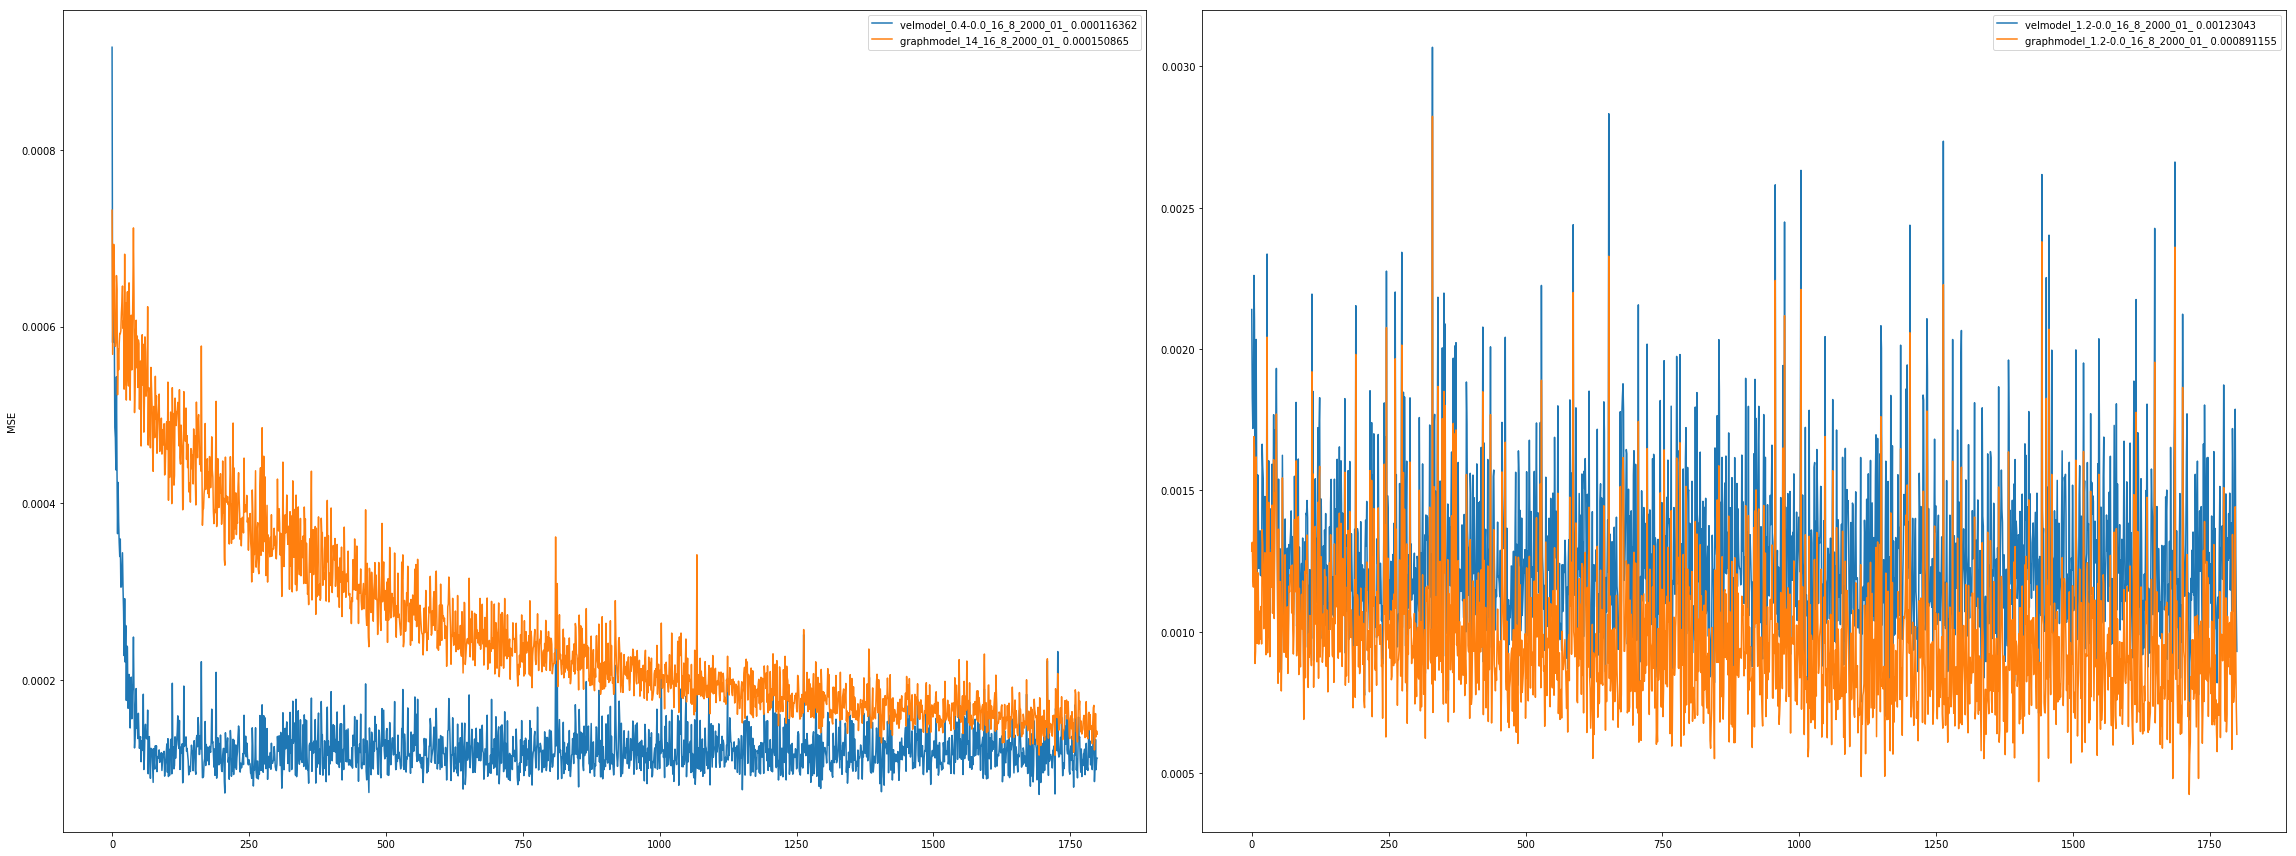

In [9]:
'''
Compare loss curves
'''
loss_labels = [#'velmodel_16_8_1000_01_',
               #'setmodel_16_8_1000_01_',
               'velmodel_0.4-0.0_16_8_2000_01_',
               'graphmodel_14_16_8_2000_01_',             
              ]
loss_labels2 = [#'velmodel_1.2-0.0_16_8_1000_01_',
                #'setmodel_1.2-0.0_16_8_1000_01_',               
               'velmodel_1.2-0.0_16_8_2000_01_',
               'graphmodel_1.2-0.0_16_8_2000_01_',
                #'velmodel_4.0-0.2_16_8_2000_01_',
                #'graphmodel_4.0-0.2_16_8_2000_01_',
              ]

loss_labels32 = ['setmodel_32_8_1000_01_',    
                ]

loss_files1 = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels]
loss_files2 = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels2]
loss_curves1 = {label:loss for label,loss in zip(loss_labels, loss_files1)}
loss_curves2 = {label:loss for label,loss in zip(loss_labels2, loss_files2)}
#iterations = np.arange(loss_files[0].shape[0])
plt.close('all')
comp_fig = plt.figure(figsize=(32, 12))
ax1 = comp_fig.add_subplot(121)
ax1.set_ylabel('MSE')
ax2 = comp_fig.add_subplot(122)
#plt.ylim([0,.001])
pstart = 200
for label, loss in loss_curves1.items():
    ax1.plot(loss[pstart:], label=(label + ' ' + str(np.mean(loss[-50:]))))
    ax1.legend()

for label, loss in loss_curves2.items():
    ax2.plot(loss[pstart:], label=(label + ' ' + str(np.mean(loss[-50:]))))
    ax2.legend()

plt.tight_layout()
#plt.savefig('Vel_Graph_04-00_40-02_trCurves', bbox_inches='tight')
plt.savefig('Vel_Set_04-00_12-00_trCurves', bbox_inches='tight')
plt.show()

In [ ]:
import mayavi
from mayavi import mlab
import numpy as np

"""
Note: this script is in it's own directory because it uses a different
      virtualenv to manage mayavi/vtk dependencies 
"""

def volumize_ptc(data_in, opacity=.5, labels=None, color=(1,0,0),frame=True, 
                 row=0, col=0, show=True, figure=None, proj=(False,True,True),
                 shadow=(False,True,True), mode='point', scale_factor=.015,
                 filename=None,):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = data_in.copy()
    data -= np.min(data, keepdims=True)
    data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj, yproj, zproj = proj
    xshadow, yshadow, zshadow = shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_mode='scalar', scale_factor=scale_factor)
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], 
                                               mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',
                    tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))

    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show: mlab.clf()
    if show: mlab.show()



def volumize_arrow(datain,# n x 3
                   arrow, #nx3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.001,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        pts = mlab.quiver3d(data[:,0], data[:,1], data[:,2], arrow[:,0], arrow[:,1], arrow[:,2], color=color, opacity=opacity, figure=figure, mode=mode)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()

j = 3 # sample

x_input = _x_in
x_truth = xt
x_pred  = xh

xtmp = x_input[j,:,:3]
bound = 0.095
lower, upper = bound, 1-bound
mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower) 
mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower) 
mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower) 
mask = mask1 * mask2 * mask3
mask_nz = np.nonzero(mask)[0]

fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))
red   = (1,0,0)
green = (0,1,0)
blue  = (0,0,1)
arrow_mode = 'arrow'
sfactor = .005

displacement = np.mean((x_truth[:,mask_nz,:3] - x_input[:,mask_nz,:3]),axis=(1,2))
greatest = np.argmax(np.abs(displacement))
least = np.argmin(np.abs(displacement))
#print('displacement: {} at {}'.format(displacement[j], j))

arrow_true  = (x_input[j,mask_nz,:3], x_truth[j,mask_nz,:3] - x_input[j,mask_nz,:3])
arrow_input = (x_input[j,mask_nz,:3], x_input[j,mask_nz,3:])
arrow_pred  = (x_input[j,mask_nz,:3], x_pred[j, mask_nz,:3] - x_input[j,mask_nz,:3])
volumize_arrow(*arrow_true,  figure=fig, color=red,   opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_input, figure=fig, color=green, opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_pred,  figure=fig, color=blue,  opacity=.3, show=True,  mode=arrow_mode)
#volumize_ptc(x_truth[j,:,:3], show=False,figure=fig, opacity=.9, color=red,  mode='point', scale_factor=sfactor)
#volumize_ptc(x_input[j,:,:3], show=False,figure=fig, opacity=.9, color=green,mode='point', scale_factor=sfactor)
#volumize_ptc( x_pred[j,:,:3], show=True, figure=fig, opacity=.9, color=blue, mode='point', scale_factor=sfactor)